In [1]:
# if True:      #A weird trick needed for Google Colab
  # Clone repository with example images
#!rm -rf fyp2022-imaging
#!git clone https://github.com/vcheplygina/fyp2022-imaging.git


import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns #For feature visualization options
from sklearn import preprocessing #For preprocessing the features

## Load ground truth labels and previously extracted features

In [2]:
# Load labels and features

file_labels = 'fyp2022-imaging/data/example_ground_truth.csv'
file_features = 'fyp2022-imaging/features/features.csv'

labels = pd.read_csv(file_labels)
features = pd.read_csv(file_features)

labels.head(),features.head()

(       image_id  melanoma  seborrheic_keratosis
 0  ISIC_0001769       0.0                   0.0
 1  ISIC_0001852       0.0                   0.0
 2  ISIC_0001871       0.0                   0.0
 3  ISIC_0003462       0.0                   0.0
 4  ISIC_0003539       0.0                   0.0,
              id      area  perimeter
 0  ISIC_0001769  216160.0     2013.0
 1  ISIC_0001852  130493.0     1372.0
 2  ISIC_0001871  205116.0     1720.0
 3  ISIC_0003462  161705.0     1344.0
 4  ISIC_0003539  317040.0     2063.0)

In [3]:

# Drop variables we do not need for nevus/melanoma classification, and combine variables we want in one place
df = labels.drop(['image_id','seborrheic_keratosis'],axis=1)
df['area'] = features['area']
df['perimeter'] = features['perimeter']

# For this demo, we do a simple split to create training and test data.
# In your project we will use more advanced methods with scikit-learn
train = df.copy()
test = df.copy()

train = train[0:100]
test = test[101:200]

train.head()

,melanoma,area,perimeter
0,0.0,216160.0,2013.0
1,0.0,130493.0,1372.0
2,0.0,205116.0,1720.0
3,0.0,161705.0,1344.0
4,0.0,317040.0,2063.0


## Explore the features

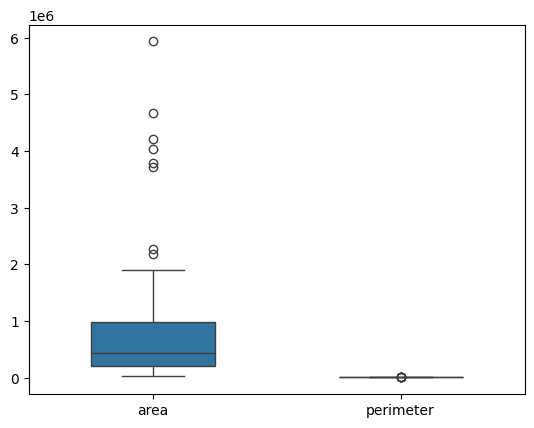

In [4]:
train_features = train[['area','perimeter']]
test_features = test[['area','perimeter']]

sns.boxplot(data=train_features, width=0.5);

[np.float64(1.5543122344752193e-17), np.float64(1.0000000000000002)]
[np.float64(4.766155105475757), np.float64(38.95073053755947)]


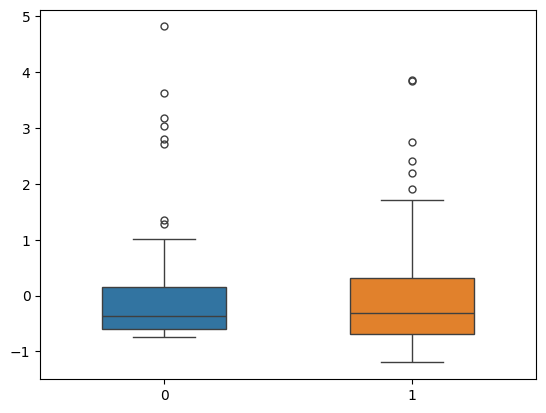

In [5]:
# The features are on different scales
# We first find out how to scale using the training data (remember you should adapt to your test data during development)
# We use the StandardScaler which scales each feature to 0 mean and 1 variance

scaler = preprocessing.StandardScaler().fit(train_features)

#Apply to data to both train and test test
train_features = scaler.transform(train_features)
test_features = scaler.transform(test_features)


#Verify
print([train_features.mean(), train_features.var()])
print([test_features.mean(), test_features.var()])

sns.boxplot(data=train_features, width=0.5,fliersize=5); #we see both negative and positive values, since the mean is 0

# Here you want to add informative labels to the axes of your plot!
# Example: https://stackoverflow.com/questions/31632637/label-axes-on-seaborn-barplot



**QUESTION**: What do you notice about these values? What happens if you increase the number of images in the train set?


*Your answer here*
.
.
.
.

float64


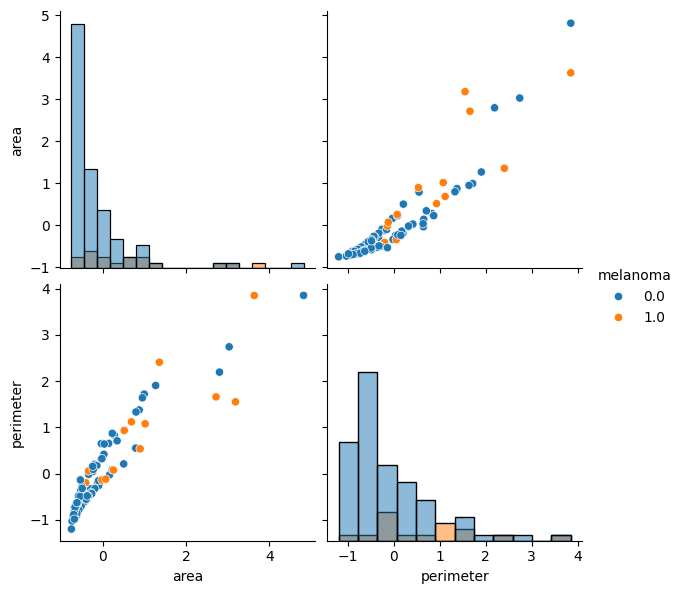

In [ ]:
# Now let's look in 2D

#If this cell fails, then the scaler may have returned a dataframe instead of an array.
#Uncomment the line below and it should run as expected
#train_features = train_features.astype('float64')

# Unfortunately, using the scaler removes the DataFrame object (it becomes a float), so we create it again
print(train_features.dtype)

train_scaled = pd.DataFrame(train_features,columns=['area','perimeter'])
train_scaled['melanoma'] = train['melanoma']

# Look at values per class
sns.pairplot(data=train_scaled, hue="melanoma", height=3, diag_kind="hist");

# Lots of other plot types are available in seaborn

In [7]:
# Let's try a classifier

from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import DecisionBoundaryDisplay


# scikit learn wants to have the features and labels separately - this is useful so we don't accidentally give the labels as a feature :D

# Train a classifier
knn1 = KNeighborsClassifier(n_neighbors=1) # other hyperparameters possible
knn1trained = knn1.fit(train_features, train['melanoma'])

knn1trained

KNeighborsClassifier(n_neighbors=1)

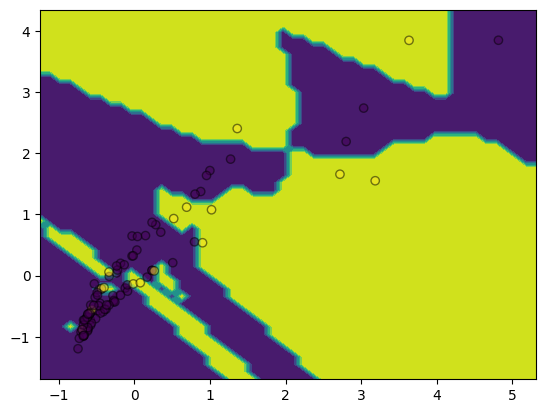

In [8]:
# Visualize the classifier

from sklearn.inspection import DecisionBoundaryDisplay

# First make a grid where we want to show the classifier
# One way to do it is to get our trained classifier to predict the labels on different points in the grid, to show the boundary

feature1_range = np.linspace(train_features[:, 0].min()-0.5,train_features[:, 0].max()+0.5)
feature2_range = np.linspace(train_features[:, 1].min()-0.5,train_features[:, 1].max()+0.5)

feature1_grid, feature2_grid = np.meshgrid(feature1_range, feature2_range)
grid = np.vstack([feature1_grid.ravel(), feature2_grid.ravel()]).T

predicted_responses = np.reshape(knn1trained.predict(grid), feature1_grid.shape)


# Now get the boundary, and plot the data on top
display = DecisionBoundaryDisplay(xx0=feature1_grid, xx1=feature2_grid, response=predicted_responses)
display.plot()
display.ax_.scatter(train_features[:, 0], train_features[:, 1], c=train['melanoma'], edgecolor="black", alpha=0.5)
plt.show()


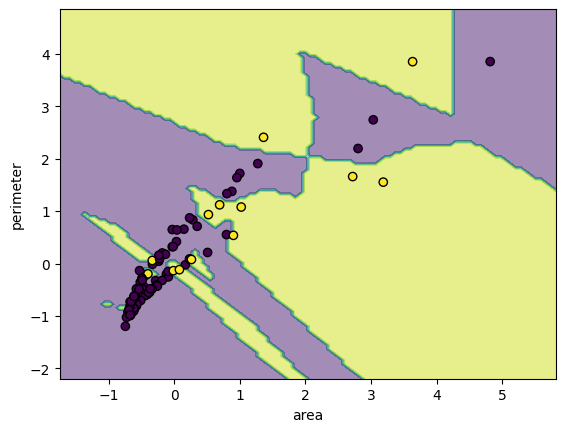

In [9]:
#An alternative way is to give the trained classifier directly

display = DecisionBoundaryDisplay.from_estimator(knn1trained, train_features, response_method="predict", xlabel='area', ylabel='perimeter', alpha=0.5)
display.ax_.scatter(train_features[:, 0], train_features[:, 1], c=train['melanoma'], edgecolor="black")
plt.show()

In [10]:
# Now let's see how this classifier performs on the test data
# Here we use accuracy as the simplest metric, but it is often NOT suitable for medical imaging
from sklearn.metrics import accuracy_score


predicted_labels = knn1trained.predict(test_features)
predicted_probs = knn1trained.predict(test_features)

test_labels = test['melanoma']

acc_knn1 = accuracy_score(test_labels, predicted_labels)
print(acc_knn1)

# For other metrics, or evaluating which examples are "most wrong", you can use the predicted probabilities




0.673469387755102


**QUESTION**: The accuracy above is not perfect but still not the worst. But what would the accuracy of a random guess be?

*Your answer here*

.

.

.

## MORE PRACTICE

If you want to practice with other features, you can use the data here: https://figshare.com/s/5cbbce14647b66286544?file=11886200